Marginalisation...

$$ P(A | B) = \frac{P(A, B)}{P(B)} = \frac{\sum_i P(A, B, C_i)}{P(B)} = \frac{\sum_i P(A | B, C_i) P(C_i | B) P(B)}{P(B)} = \sum P(A | B, C_i) P(C_i | B) = \int P(A | B, C) P(C | B) \ dC $$

$$ P(\theta | \log L) \propto P(\log L | \theta) P(\theta) $$
$$ = \int P(\log L | \theta, X) P(X|\theta) P(\theta) \ dX$$
$$ \therefore P(\theta | \log L) \propto \int P(\log L | \theta, X) P(\theta|X) P(X) \ dX$$

Previously, we said that $P(\theta | \log L) \propto \int P(\log L | \theta, X) P(X) \ dX$ - differs by $P(\theta|X)$

What is $P(\theta|X)$? Previously took $P(\theta)$ to be constant; not sure if we can do it here

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_Sigmainv, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params
from aeons.bayes import logPr_bayes, logPr_laplace, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
simple_log, middle_log, full_log = simple_like(logX=True), middle_like(logX=True), full_like(logX=True)
from aeons.hessian import hess_autograd

In [2]:
def get_logprs(ds, logpr, *args):
    logprs = np.zeros_like(ds)
    for i, d in enumerate(ds):
        logprs[i] = logpr(*args, d)
    return logprs
def linear_step(X, theta, steps=10):
    return theta * np.floor(X * steps)/steps

In [26]:
# nk = 500 * np.ones(1000)
nk = data_at_iteration(samples_g_1, 2000)[0]
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)

### Quad

(array([9.93029785]), array([6.33132549]))

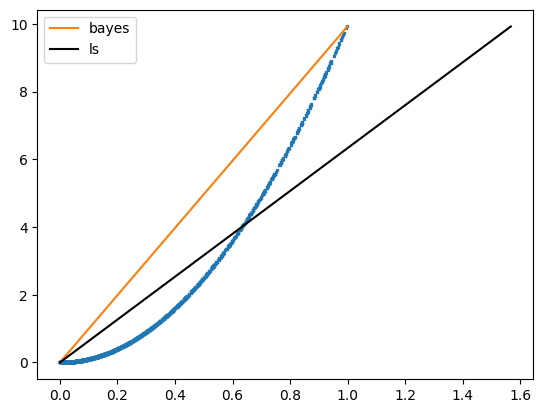

In [10]:
X = generate_Xs(nk)
theta_true = 10
y = quad.func(X, theta_true)
theta_b = minimise_bayes(y, linear, mean_X, covinv_X, theta_true).x
theta_l = minimise_ls(y, linear, mean_X, theta_true).x
plt.plot(X, y, 'x', ms=2)
plt.plot(linear.inverse(y, theta_b), y, label='bayes')
plt.plot(linear.inverse(y, theta_l), y, label='ls', color='black')
plt.legend();
theta_b, theta_l

### Linear step

(array([24.12664795]), array([8.91727507]))

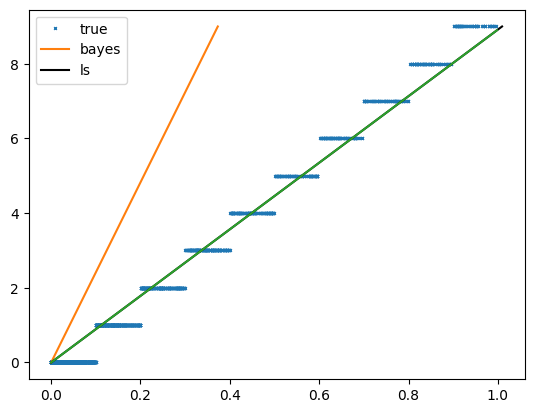

In [27]:
X = generate_Xs(nk)
theta_true = 10
y = linear_step(X, theta_true, 10)
theta_b = minimise_bayes(y, linear, mean_X, covinv_X, theta_true).x
theta_l = minimise_ls(y, linear, mean_X, theta_true).x
plt.plot(X, y, 'x', ms=2, label='true')
plt.plot(linear.inverse(y, theta_b), y, label='bayes')
plt.plot(linear.inverse(y, theta_l), y, label='ls', color='black')
plt.plot(mean_X, linear.func(mean_X, theta_l))
plt.legend();
theta_b, theta_l

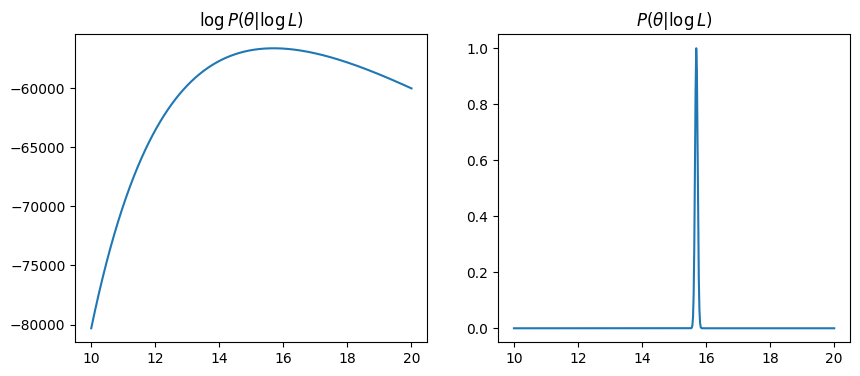

In [56]:
ds = np.linspace(10, 20, 500)
logprs = get_logprs(ds, logPr_bayes, y, linear, mean_X, covinv_X)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(ds, logprs)
ax1.set_title(r'$\log P(\theta|\log L)$')
ax2.plot(ds, np.exp(logprs-logprs.max()))
ax2.set_title(r'$P(\theta|\log L)$');

### Simple step

In [5]:
nk = 500 * np.ones(1000)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
mean_logX = logX_mu(nk)
covinv_logX = logX_Sigmainv(nk)

In [13]:
def wedding_like_simple(X, theta):
    d = theta
    def i(x):
        """Plateau number of a parameter point."""
        r = abs(x)
        return np.floor(d*np.log(r))
    def logL(x):
        """Gaussian log-likelihood."""
        ri = np.exp((i(x)/d))
        return - ri**(2/d)
    return logL(X)

In [28]:
theta_true = 10
X = generate_Xs(nk)
y = wedding_like_simple(X, theta_true)
theta_b = minimise_bayes(y, simple, mean_X, covinv_X, 9).x
theta_b

array([17.12290649])

In [30]:
theta_ls = minimise_ls(y, simple, mean_X, 10).x

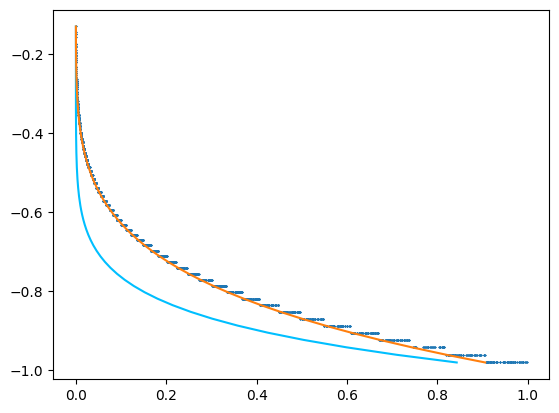

In [31]:
plt.plot(X, y, 'x', ms=1)
plt.plot(simple.inverse(y, theta_b), y, color='deepskyblue')
plt.plot(simple.inverse(y, theta_ls), y)
# plt.plot(X, -X**(2/d)/(2*sigma**2));

### Normal

In [71]:
nk, logL = data_at_iteration(samples_g_1, 1500)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)

In [72]:
minimise_bayes(logL, full, mean_X, covinv_X, [0, 10, 0.01]).x, minimise_ls(logL, full, mean_X, [0, 10, 0.01]).x

(array([-0.0972027 ,  9.56698054,  0.10010256]),
 array([-1.2043102 ,  9.36683616,  0.10154148]))

In [84]:
import emcee

def log_prior_full(theta):
    logLmax, d, sigma = theta
    if -9.0 < logLmax < 0.0 and 1.0 < d < 15.0 and 0.05 < sigma < 0.15:
        return 0.0
    return -np.inf


def log_prob_full(theta, logL, mean, covinv):
    logPr = logPr_bayes(logL, full, mean, covinv, theta)
    lp = log_prior_full(theta)
    if not np.isfinite(lp):
        return -np.inf
    return logPr

In [97]:
nwalkers = 32
steps = 2000
ndim_fixed = 3
logLmax0 = np.random.uniform(-9, 0, (nwalkers,))
d0 = np.random.uniform(1, 15, (nwalkers,))
sigma0 = np.random.uniform(0.05, 0.15, (nwalkers,))
p0_fixed = np.array([logLmax0, d0, sigma0]).T # set initial positions of the walkers
sampler_fixed = emcee.EnsembleSampler(nwalkers, ndim_fixed, log_prob_full, args=[logL, mean_X, covinv_X])
sampler_fixed.run_mcmc(p0_fixed, steps)
flat_samples = sampler_fixed.get_chain(flat=True)

In [98]:
flat_samples.shape

(64000, 3)

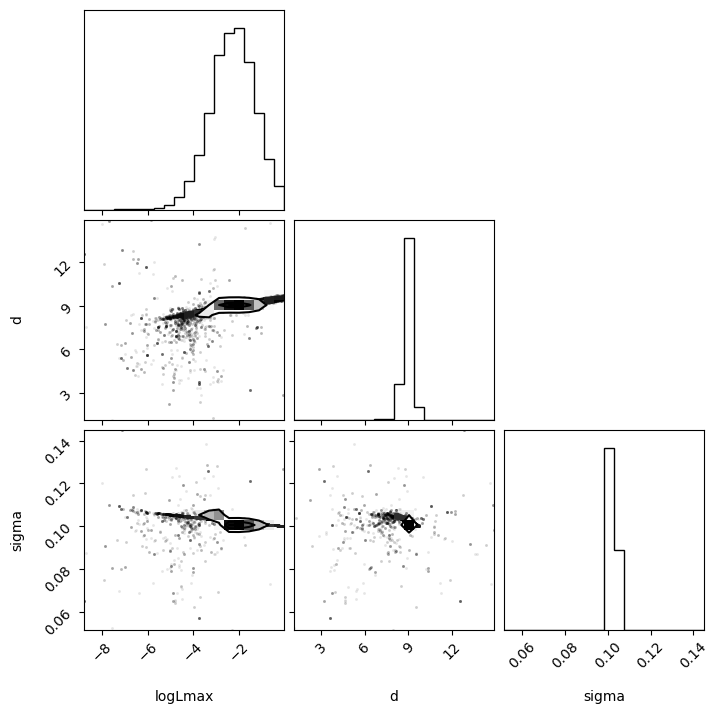

In [99]:
import corner

fig = corner.corner(
    flat_samples, labels=['logLmax', 'd', 'sigma']
);

In [58]:
nk, logL = data_at_iteration(samples_g_1, 1500)
nk = nk[-500:]
logL = logL[-500:]
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)

In [59]:
minimise_bayes(logL, full, mean_X, covinv_X, [0, 10, 0.01]).x, minimise_ls(logL, full, mean_X, [0, 10, 0.01]).x

(array([-0.02925765, 10.11704113,  0.13695586]),
 array([ 2.58326181, 11.07444529,  0.13038684]))

In [64]:
nk = data_at_iteration(samples_g_1, 1000)[0]

In [65]:
X_true = generate_Xs(nk)
y = full.func(X_true, [0, 10, 0.01])

In [66]:
nk = nk[-500:]
y = y[-500:]
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)

In [67]:
minimise_bayes(y, full, mean_X, covinv_X, [0, 10, 0.01]).x

array([-9.45045102e-04,  1.01037923e+01,  1.21427981e-02])

In [63]:
minimise_bayes(y, full, mean_X, covinv_X, [0, 10, 0.01]).x

array([8.48355849e-06, 1.01980919e+01, 9.99808786e-03])